In [1]:
import numpy as np
import tensorflow as tf

import scipy
import scipy.stats

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = True
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
# from model2 import Model
from options import get_options
from place_cells import PlaceCells
from data_manager import DataManager
from model import RNN, LSTM
from trainer import Trainer

/home/bsorsch/.tf2/lib/python3.5/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
options = get_options()
model = RNN(options)
place_cells = PlaceCells(options)
data_manager = DataManager(options, place_cells)
trainer = Trainer(options, model, data_manager)

Restored from /data3/bsorsch/grid_cell_models/steps_10_batch_200_RNN_256_relu_rf_01_DoG_True_periodic_False_lr_00001/ckpts/ckpt-25


In [5]:
options

{'DoG': True,
 'Ng': 256,
 'Np': 512,
 'RNN_type': 'RNN',
 'activation': 'relu',
 'batch_size': 200,
 'box_height': 1.1,
 'box_width': 1.1,
 'learning_rate': 0.0001,
 'n_epochs': 100,
 'n_steps': 500,
 'periodic': False,
 'place_cell_rf': 0.1,
 'run_ID': 'steps_10_batch_200_RNN_256_relu_rf_01_DoG_True_periodic_False_lr_00001',
 'save_dir': '/data3/bsorsch/grid_cell_models',
 'sequence_length': 10,
 'surround_width': 3}

# Task statistics

In [40]:
inputs, pos, pc_outputs = data_manager.get_test_batch()
pc_outputs = tf.reshape(pc_outputs, (-1, options['Np']))
pc = place_cells.grid_pc(pc_outputs[::100])

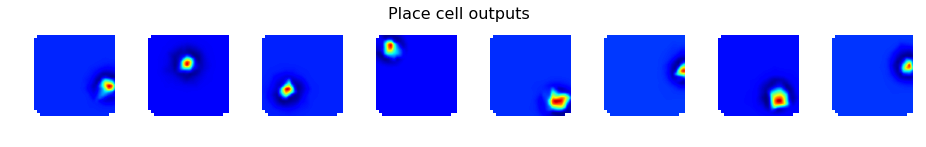

In [41]:
plt.figure(figsize=(16,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(pc[i], cmap='jet', interpolation='gaussian')
    plt.axis('off')
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()
# plt.tight_layout()

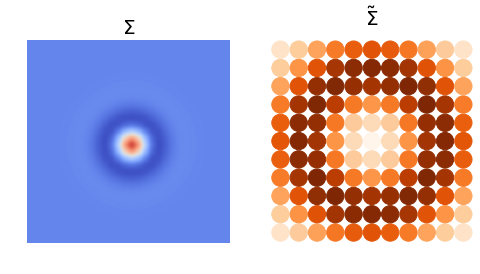

In [42]:
# Get place cell covariance matrix
Cmean = place_cells.compute_covariance(res=30)

# Fourier transform
Ctilde = np.fft.fft2(Cmean)
Ctilde[0,0] = 0

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(Cmean, cmap='coolwarm', interpolation='gaussian')
plt.axis('off')
plt.title(r'$\Sigma$', fontsize=20)

plt.subplot(122)
width = 6
idxs = np.arange(-width+1, width)
x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))
plt.scatter(x2,y2,c=np.abs(Ctilde)[idxs][:,idxs], s=300, cmap='Oranges')
# plt.colorbar()
plt.axis('equal')
plt.axis('off')
plt.title(r'$\tilde \Sigma$', fontsize=20)
plt.axis('off');
# plt.savefig('images/J_Jfft.pdf', transparent=True)

# Train model

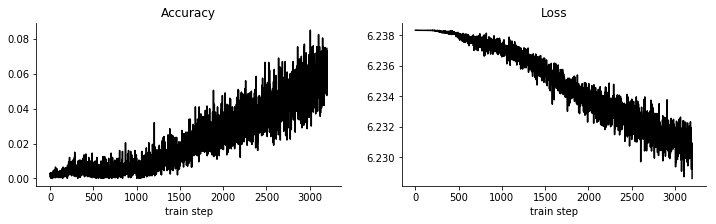

In [36]:
trainer.train(n_epochs=1, n_steps=1000, save=False)

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(trainer.acc, c='black')
plt.title('Accuracy'); plt.xlabel('train step')
sns.despine()
plt.subplot(122)
plt.plot(trainer.loss, c='black');
plt.title('Loss'); plt.xlabel('train step')
sns.despine()

## Evaluate performance

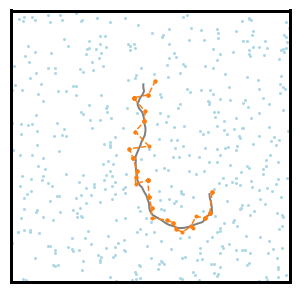

In [226]:
inputs, pos, pc_outputs = data_manager.get_test_batch()
true_pos = place_cells.get_nearest_cell_pos(pc_outputs)
pred_pos = place_cells.get_nearest_cell_pos(model.predict(inputs))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(1):
    plt.plot(pos[i,:,0], pos[i,:,1], c='grey', label='True position', linewidth=2)
    plt.plot(pred_pos[i,:,0], pred_pos[i,:,1], '.-',
             c='C1', linestyle='dashed', label='Decoded position')
#     if i==0:
#         plt.legend()
plt.scatter(place_cells.us[:,0], place_cells.us[:,1], s=4, alpha=1, c='lightblue')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
plt.xticks([])
plt.yticks([])
plt.locator_params(nbins=2)
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1]);
# plt.savefig('images/sim_traj_decode.pdf')

# Ratemaps

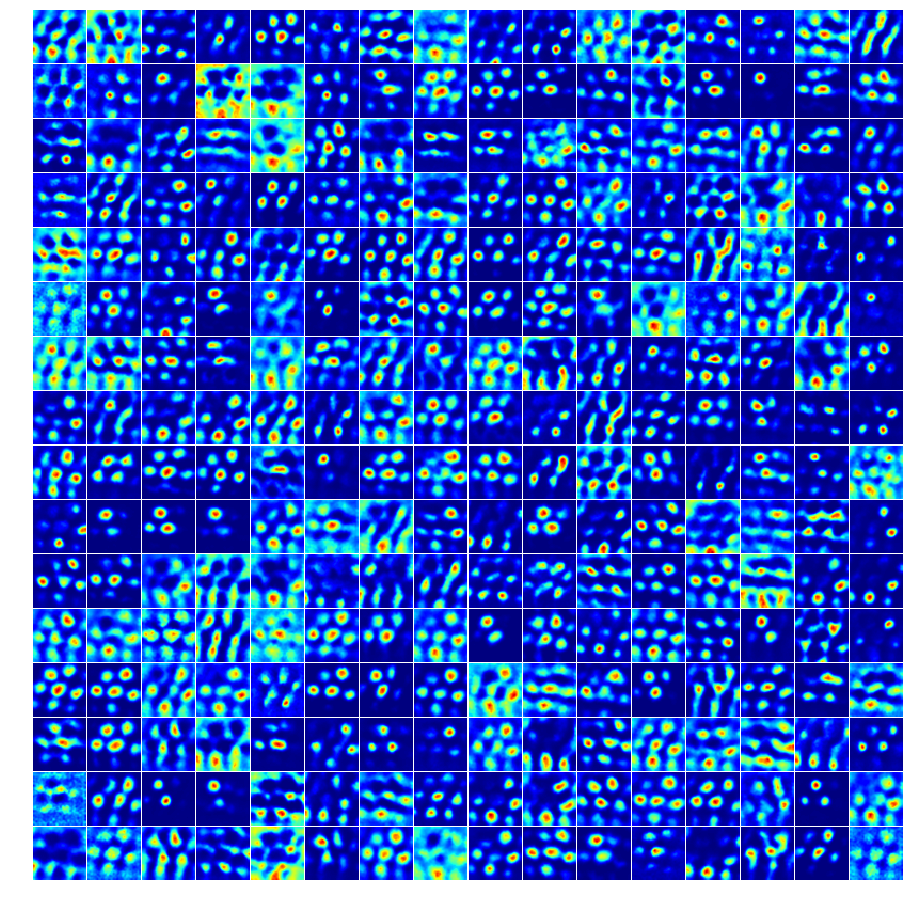

In [6]:
from visualize import compute_ratemaps, plot_ratemaps
res = 50
n_avg = 100
activations, rate_map, g, pos = compute_ratemaps(model, data_manager, options, res=res, n_avg=n_avg)

n_plot = 256
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations, n_plot, smooth=True)
plt.imshow(rm_fig)
plt.axis('off');

In [7]:
# Fourier transform 
Ng = options['Ng']
rm_fft_real = np.zeros([Ng,res,res])
rm_fft_imag = np.zeros([Ng,res,res])

for i in tqdm(range(Ng)):
    rm_fft_real[i] = np.real(np.fft.fft2(rate_map[i].reshape([res,res])))
    rm_fft_imag[i] = np.imag(np.fft.fft2(rate_map[i].reshape([res,res])))
    
rm_fft = rm_fft_real + 1j * rm_fft_imag

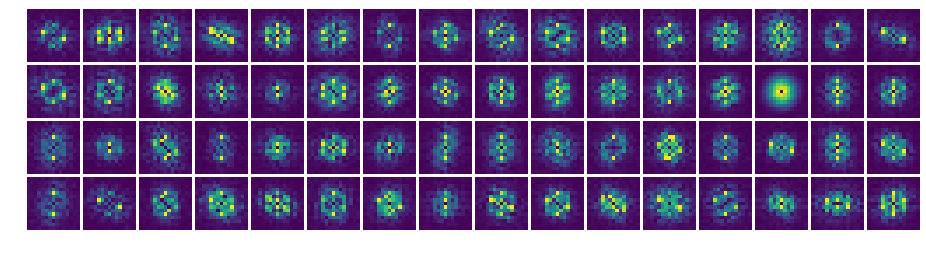

In [9]:
n_plot = 64
# plt.figure(figsize=(16,4*n_plot//8**2))
plt.figure(figsize=(16,10))

idxs = np.arange(-7,8)
rm_plot = np.abs(rm_fft)
rm_plot[:,0,0] = 0
rm_plot = rm_plot[:,idxs][:,:,idxs]
rm_fft_fig = plot_ratemaps(rm_plot, n_plot, cmap='viridis', width=16, smooth=False)
plt.imshow(rm_fft_fig)
plt.axis('off');

Text(0.5, 1.0, 'Mean power')

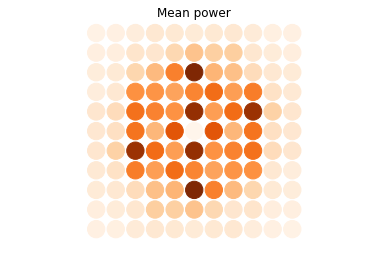

In [10]:
im = np.mean(np.abs(rm_fft), axis=0)
im[0,0] = 0

width = 6
idxs = np.arange(-width+1, width)
x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))
im = np.abs(rm_fft).mean(0)
im[0,0] = 0
plt.scatter(x2,y2,c=im[idxs][:,idxs], s=300, cmap='Oranges')
# plt.colorbar()
plt.axis('equal')
plt.axis('off');
plt.title('Mean power')

## SVD

In [11]:
# Perform SVD
# X = rate_map
Ng = options['Ng']
X_unroll = rate_map.reshape(Ng, res, res)
crop = 0
X_crop = X_unroll[:,crop:res-crop, crop:res-crop]
X = X_crop.reshape(Ng, -1)
U, S, V = scipy.linalg.svd(X - np.mean(X, axis=1)[:, np.newaxis])

rm_embed = U.T@X

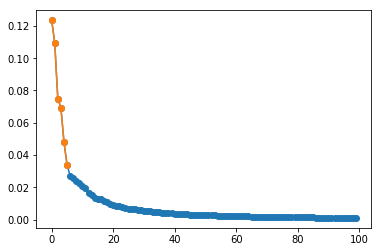

In [12]:
plt.plot(S[:100]/np.sum(S), 'o-', c='C0')
# plt.plot(S[:12]/np.sum(S), 'o-', c='C1')
plt.plot(S[:6]/np.sum(S), 'o-', c='C1')

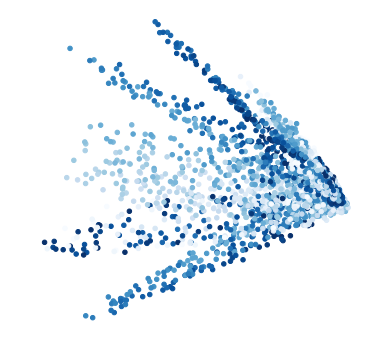

In [13]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
blues = mpl.colors.ListedColormap(sns.color_palette("Blues", n_colors=256))

cmap = mpl.colors.ListedColormap(sns.husl_palette(256))
x = np.repeat(np.arange(res), res)
y = np.tile(np.arange(res), res)
ax.scatter(rm_embed[0, :], rm_embed[1, :],
           c=np.mod(y, res//2), s=20, cmap=blues, label='RNN states')
plt.axis('off')
plt.show()

## Ring fit

In [14]:
x = np.tile(np.arange(res-2*crop), res-2*crop)*2*np.pi/(res)
y = np.repeat(np.arange(res-2*crop), res-2*crop)*2*np.pi/(res)
x60 = np.asarray([0.5, 0.5*np.sqrt(3)]).dot(np.stack([x,y]))
x120 = np.asarray([-0.5, 0.5*np.sqrt(3)]).dot(np.stack([x,y]))
y60 = np.asarray([0.5, 0.5*np.sqrt(3)]).dot(np.stack([y,x]))
y120 = np.asarray([-0.5, 0.5*np.sqrt(3)]).dot(np.stack([y,x]))

vecs = [x,x60,x120,y,y60,y120]

hsl = mpl.colors.ListedColormap(sns.husl_palette(256))
blues = mpl.colors.ListedColormap(sns.color_palette("Blues", n_colors=256))
greens = mpl.colors.ListedColormap(sns.color_palette("Greens", n_colors=256))
oranges = mpl.colors.ListedColormap(sns.color_palette("Oranges", n_colors=256))

cmaps = [blues, greens, oranges, blues, greens, oranges]

colors = [x,x60,x120,y,y60,y120]

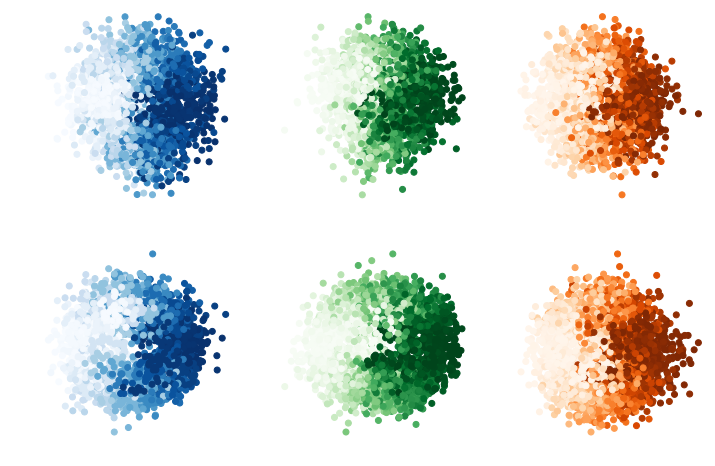

In [17]:
# Construct torus 
freq = 3
X1 = np.stack([np.cos(freq*x), np.sin(freq*x), np.cos(freq*x60),
               np.sin(freq*x60), np.cos(freq*x120), np.sin(freq*x120)])
X2 = np.stack([np.cos(freq*y), np.sin(freq*y), np.cos(freq*y60),
               np.sin(freq*y60), np.cos(freq*y120), np.sin(freq*y120)])
X = np.concatenate([X1,X2], axis=0)

# Find rotation
RM = rm_embed[:128]
R = np.linalg.inv(RM.dot(RM.T)).dot(RM).dot(X.T).T

# Plot rings
plt.figure(figsize=(12,8))
for i in range(R.shape[0]//2):
    plt.subplot(2,3,i+1)
#     plt.scatter(R.dot(RM)[2*i], R.dot(RM)[2*i+1], c=np.mod(colors[i], 2*np.pi/freq), cmap=cmaps[i])
    plt.scatter(R.dot(RM)[2*i], R.dot(RM)[2*i+1], c=np.cos(freq*vecs[i]), cmap=cmaps[i])
#     plt.scatter(np.linalg.inv(R.dot(R.T)).dot(R).dot(RM)[2*i],
#                 np.linalg.inv(R.dot(R.T)).dot(R).dot(RM)[2*i+1], c=np.mod(colors[i], 2*np.pi/freq), cmap=cmaps[i])
    plt.axis('off')

## Sort

In [18]:
mean_power = np.mean(np.abs(rm_fft), axis=0)
power_sort_unravel = np.argsort(mean_power.ravel())
power_sort = np.unravel_index(power_sort_unravel, mean_power.shape)

In [19]:
# rm_fft_x = rm_fft[:,2,0]
# rm_fft_x60 = rm_fft[:,1,2]
# rm_fft_x120 = rm_fft[:,-1,2]
# rm_fft_y = rm_fft[:,0,2]
# rm_fft_y60 = rm_fft[:,2,1]
# rm_fft_y120 = rm_fft[:,2,-1]

rm_fft_x = rm_fft[:,3,0]
rm_fft_x60 = rm_fft[:,1,3]
rm_fft_x120 = rm_fft[:,-2,3]
rm_fft_y = rm_fft[:,0,3]
rm_fft_y60 = rm_fft[:,3,1]
rm_fft_y120 = rm_fft[:,3,-2]

(0, 0.0002445333162313001)

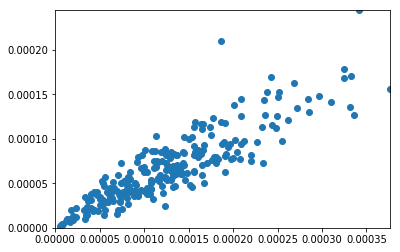

In [20]:
abs_rm_x_tot = np.abs(rm_fft_x)+np.abs(rm_fft_x60)+np.abs(rm_fft_x120)
x_power = abs_rm_x_tot / np.sum(np.abs(rm_fft))
abs_rm_y_tot = np.abs(rm_fft_y)+np.abs(rm_fft_y60)+np.abs(rm_fft_y120)
y_power = abs_rm_y_tot / np.sum(np.abs(rm_fft))
plt.scatter(x_power, y_power)
plt.xlim([0,np.max(x_power)])
plt.ylim([0,np.max(y_power)])

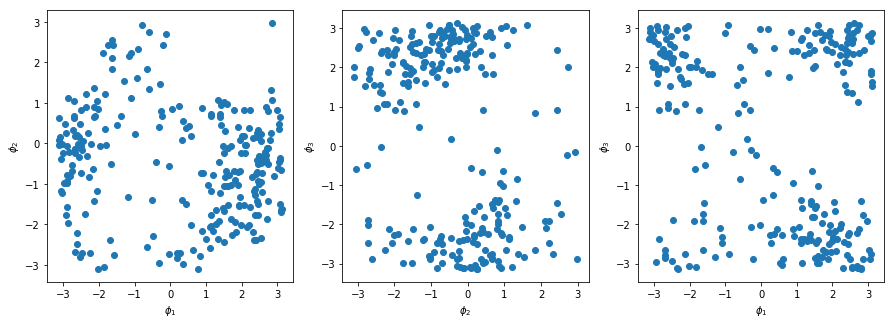

In [21]:
# Find phases
phase_1 = np.angle(rm_fft_x)
p1_sort = np.argsort(-phase_1)

phase_2 = np.angle(rm_fft_x60)
p2_sort = np.argsort(-phase_2)

phase_3 = np.angle(rm_fft_x120)
p3_sort = np.argsort(-phase_3)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(phase_1, phase_2)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.subplot(132)
plt.scatter(phase_2, phase_3)
plt.xlabel(r'$\phi_2$')
plt.ylabel(r'$\phi_3$')
plt.subplot(133)
plt.scatter(phase_1, phase_3)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_3$')
plt.show()

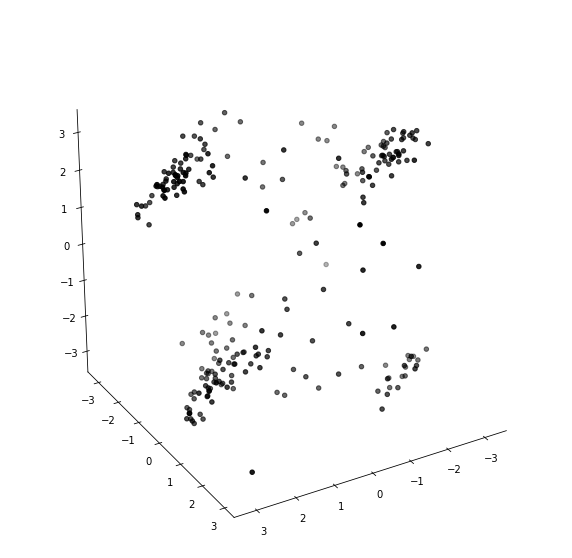

In [22]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')


# ax.scatter(phase_1, phase_2, phase_3, c='C0')
# ax.scatter(phase_1[idxs[1000:]], phase_2[idxs[1000:]], phase_3[idxs[1000:]], c='C1')
ax.scatter(phase_1, phase_2, phase_3, c='black')
ax.view_init(azim=60)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

In [23]:
def get_2d_sort(x1,x2):
    """2D sort
    Reshapes x1 and x2 into square arrays, and then sorts
    them such that x1 increases downward and x2 increases
    rightward. Returns the order.
    """
    n = int(np.round(np.sqrt(len(x1))))
    total_order = x1.argsort()
    total_order = total_order.reshape(n,n)
    for i in range(n):
        row_order = x2[total_order.ravel()].reshape(n,n)[i].argsort()
        total_order[i] = total_order[i,row_order]
    total_order = total_order.ravel()
    return total_order

In [24]:
N = rate_map.shape[0]
width = int(np.sqrt(N))
freq = 1
X,Y = np.meshgrid(np.arange(width),np.arange(width))
X = X*2*np.pi/width
Y = Y*2*np.pi/width

s1 = np.zeros(phase_1.shape)
s2 = np.zeros(phase_1.shape)

fac = np.sqrt(3)/2

for i in range(Ng):
    penalty_1 = np.cos(freq*X - phase_1[i]/fac)
    penalty_2 = np.cos(freq*Y - phase_3[i]/fac)
    penalty_3 = np.cos(freq*(X+Y) - phase_2[i]/fac)
#     penalty_4 = np.cos(freq*(Y-X) - phase_4[i]/fac)
    ind = np.argmax(penalty_1+penalty_2 + penalty_3  + np.random.randn()/100)
    s1[i],s2[i] = np.unravel_index([ind],penalty_1.shape)
    
total_order = get_2d_sort(s1,s2)

In [25]:
rm_sort_square = rate_map[total_order.ravel()].reshape([width,width,-1])

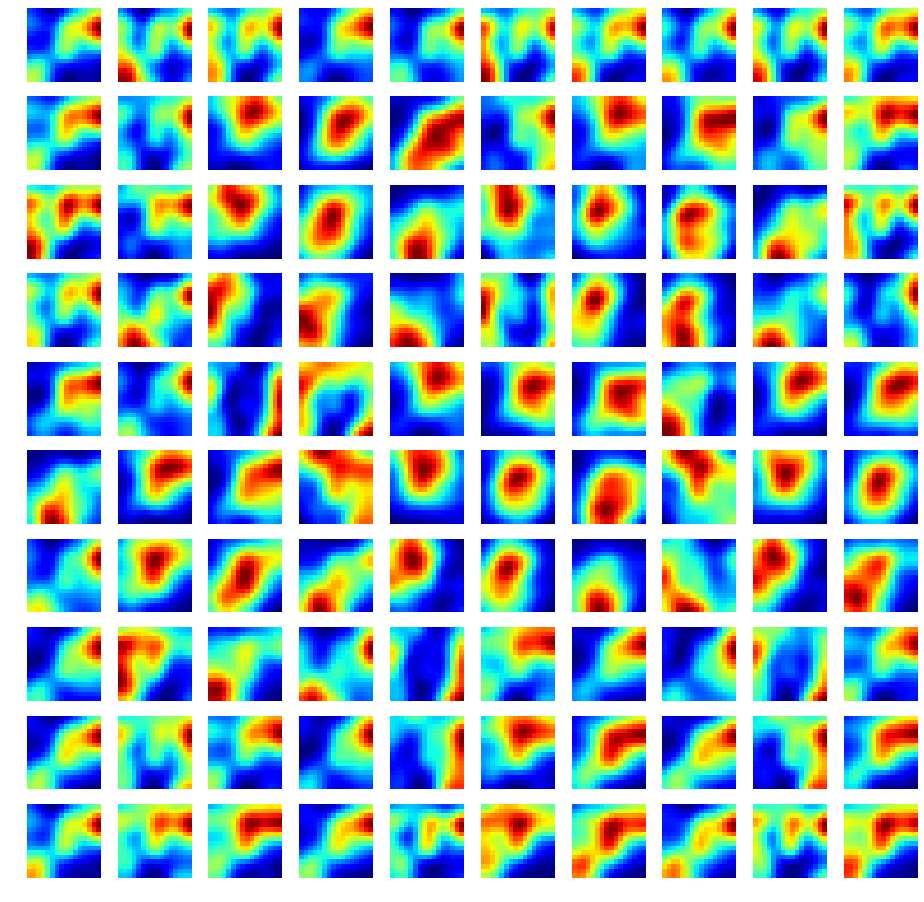

In [26]:
fig, axes = plt.subplots(10,10, figsize=(16,16))
for i in range(10):
    for j in range(10):
        im = rm_sort_square[:,:,5*50*i + 5*(10-j)]
#         im = np.tile(im, (3,3))
        im = scipy.ndimage.gaussian_filter(im, sigma=(2,2))
        axes[i,j].imshow(im, cmap='jet')
        axes[i,j].axis('off')

In [ ]:
# Define skew matrix
A = np.asarray([[2,1],[0, np.sqrt(3)]])/4
Ainv = np.linalg.inv(A)

fig, axes = plt.subplots(10,10, figsize=(16,16))
for j in range(10):
    for i in range(10):
        im = rm_sort_square[:,:,5*50*i + 5*(10-j)]
#         im = np.tile(im, (3,3))
        im = scipy.ndimage.affine_transform(im, Ainv, mode='wrap')
        im = scipy.ndimage.gaussian_filter(im, sigma=(2,2))
        axes[i,j].imshow(im.T, cmap='jet')
        axes[i,j].axis('off')

# Weights

In [27]:
J = model.RNN.weights[1].numpy()

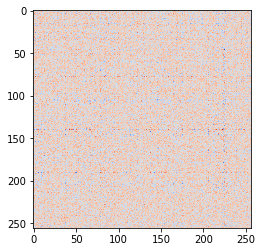

In [28]:
plt.imshow(J, cmap='coolwarm')

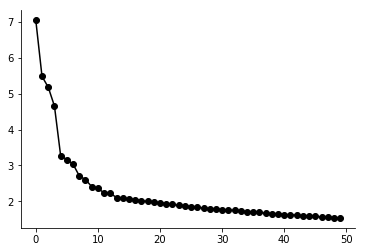

In [29]:
U,S,V = np.linalg.svd(J)
plt.plot(S[:50], 'o-', c='black')
sns.despine();

In [30]:
eigs, eigvs = np.linalg.eig(J)

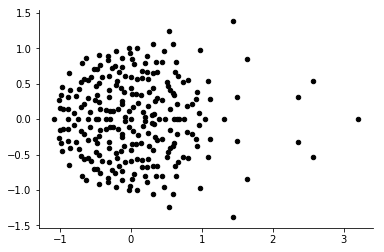

In [31]:
plt.scatter(np.real(eigs), np.imag(eigs), c='black', s=20)
plt.axis('equal')
sns.despine()

## Sort weights

In [32]:
n = int(np.sqrt(Ng))
Jsort = J[total_order][:, total_order]
J_square = np.reshape(Jsort, (n,n,n,n))

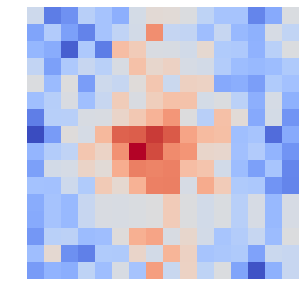

In [33]:
Jmean = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        Jmean += np.roll(np.roll(J_square[i,j], -i, axis=0), -j, axis=1)
        
Jmean[0,0] = np.max(Jmean[1:,1:])
Jmean = np.roll(np.roll(Jmean, n//2, axis=0), n//2, axis=1)
# plt.imshow(Jmean, cmap='coolwarm', interpolation='gaussian')

A = np.asarray([[2,1],[0, np.sqrt(3)]])/2
Ainv = np.linalg.inv(A)
im = scipy.ndimage.affine_transform(Jmean, Ainv, mode='wrap')

imroll = np.roll(np.roll(im, -n//4, axis=0), 0, axis=1)
# imroll = scipy.ndimage.gaussian_filter(imroll, sigma=(1,1))

plt.figure(figsize=(5,5))
plt.imshow(imroll, cmap='coolwarm')
plt.axis('off');